# Example with flow in a channel with a bump

This is a test case with particles released in a simple looping flow field
The depth profile is given by: 

$d(x) = d_m - d_b * bump(x,l_b)$

Where:
- $d_m$ is the mean depth
- $d_b$ is the height of the bump
- $l_b$ is the length of the bump
- $L$ is half the length of the channel
- $u_m$ is the mean flow 

The domain is $x \in [-L,L], y \in [-d_m,0]$


Two test cases are embedded.
The first test case tests the algorithm that divides the timestep by half, takes a new random number and thus weakens the strength of diffusion strength and "controlls" the direction of turbulent velocity. To test the algorithm, we only add one particle into the computation domain and set the keyword parameter "if_cross_bc" = true.

In [1]:
# Load required libraries
using Pkg
Pkg.precompile() # command needed after modifying the src code
Pkg.activate("..")
using Particles
using Plots
using Random

#rng_recursion = MersenneTwister(1234) 

nothing

  Activating project at `j:\Master_Thesis\particles.jl`


In [111]:
# Randompool setup and restart

randpool = MersenneTwister(123) #Generate same random numbers every time


MersenneTwister(123)

In [133]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults
d["rng"] = randpool



MersenneTwister(123, (0, 1002, 0, 308))

In [134]:

# settings for this experiment
n = 1 # number of particles
d["nparticles"] = n
# problem specific settings
d_b = 4.0
d["d_b"] = d_b # height of the bump [m]
l_b=300.0
d["l_b"] = l_b# length of the bump [m]
d_m=10.0
d["d_m"] = d_m # mean depth [m]
u_m=1.0
d["u_m"] = u_m # mean flow [m/s]
L=500.0
d["L"] = 500.0 # half the length of the channel [m]
# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = (-0.9*L) .+ 0.01 .* L .* randn(randpool, n, 1) # particles are spawned close to the left boundary
p[3, :] = (-d_m) .+ 1.0 .* d_m .* rand(randpool, n, 1)
d["particles"] = p # initial values
# simulation time
d["dt"] = 1.0     #time-step
d["tstart"] = 0.0 
d["tend"] = 300.0 #800
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:10.0:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_loop.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:10.0:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(0.0:10.0:tend)

nothing



In [135]:
# if initialize particle location to perform the single particle test

#p = [-452.01034034514936,0.0,-8.633525058830664,0.0] # will end up hitting the lower boundary
#p = [-452.01034034514936,0.0,-1.833525058830664,0.0]
p = [-200.01034034514936,0.0,-8.53525058830664,0.0] # will end up hitting the lower boundary

d["particles"] = reshape(p, length(p), 1)

4×1 Matrix{Float64}:
 -200.01034034514936
    0.0
   -8.53525058830664
    0.0

In [136]:
# the following options are to be added in the default_userdata() function
# if to apply the algorithm to prevent the algorithm from crossing the boundary or not
d["if_cross_bc"] = true
d["if_apply_cross_bc_test"] = true # if applied, only one particle is used and all virtual trajectories are also recorded
if d["if_apply_cross_bc_test"]
    d["the_virtual_trajectory"] = d["particles"]
end
d["if_keep_these_particles"] = trues(d["nparticles"],)

1-element BitVector:
 1

In [137]:
d #show configuration

Dict{String, Any} with 34 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [-200.01; 0.0; -8.53525; 0.0;;]
  "nparticles"           => 1
  "plot_maps_times"      => [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.…
  "dt"                   => 1.0
  "tend"                 => 300.0
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_loop.nc"
  "L"                    => 500.0
  "d_m"                  => 10.0
  "variables"            => ["x", "y", "z", "age"]
  "keep_particle_times"  => [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.…
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "plot_maps_func"       => plot_maps_xz
  "coordinates"          => "projected"
  ⋮                      => ⋮

In [138]:
p

4-element Vector{Float64}:
 -200.01034034514936
    0.0
   -8.53525058830664
    0.0

In [139]:
d["particles"]

4×1 Matrix{Float64}:
 -200.01034034514936
    0.0
   -8.53525058830664
    0.0

In [140]:
# Define the flow field

# bump function
function bump(x, l_b)
    if abs(x) < l_b
        return 0.5 * (1.0 + cos(pi * x / l_b))
    else
        return 0.0
    end
end

function derivative_bump(x, l_b)
    if abs(x) < l_b
        return -0.5 * pi / l_b * sin(pi * x / l_b)
    else
        return 0.0
    end
end

# depth profile
function depth(x, d_m, d_b, l_b)
    d_m - d_b * bump(x, l_b)
end

d["depth"] = x -> depth(x, d_m, d_b, l_b)

# derivative of depth profile
function derivative_depth(x, d_m, d_b, l_b)
    -d_b * derivative_bump(x, l_b)
end

# Stream function with value 0 at the surface and u_m * d_m at the bottom
# Note that the depth is variable
function stream(x, y, z, t)
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return -u_m * d_m
    else
        return -u_m * d_m * z / d_x
    end
end

# flow in x direction (for now has to be called u)
function u(x, y, z, t)
    # u=-s_z
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return 0.0
    else
        return u_m * d_m / d_x
    end
end


# flow in y direction (for now has to be called v)
function v(x, y, z, t)
    return 0.0
end

# flow in y direction (for now has to be called w)
function w(x, y, z, t)
   # w=s_x
   d_m = d["d_m"]
   d_b = d["d_b"]
   l_b = d["l_b"]
   u_m = d["u_m"]
   d_x = depth(x, d_m, d_b, l_b) # depth at x
   if z>0.0
       return 0.0
   elseif z<-d_x
       return 0.0
   else
       return u_m * d_m * z / d_x^2 * derivative_depth(x, d_m, d_b, l_b)
   end
end

nothing

In [141]:
# add diffusion profile
function parabola_diffusion(z)
    H = 1 # unit length water column
    if z<=H && z>=0
        return 6 * z  * (1-z) *0.1
    else 
        return 0
    end
end

# add diffusion profile
function derivative_parabola_diffusion(z)
    H = 1 # unit length water column
    if z<=H && z>=0
        return (6 - 12 *z) * 0.1
    else 
        return 0
    end
end

function double_parabola_diffusion(z,a=1, magnitude=1.0)
    # input with reference coordinate z, shape parameter a and magnitude z
    H = 1 # unit length water column
    c = 2*(1+a)*(1+2*a)/(a*a*H^(1+1/a))
    if z>=0 && z<=H/2
        return magnitude* c *z*(H-2*z)^(1/a)
    else
        return magnitude* c *(H-z)*(2*z-1)^(1/a)
    end
end

function derivative_double_parabola_diffusion(z, a=1, magnitude=1.0)
    # input with reference coordinate z, shape parameter a and magnitude z
    H = 1 # unit length water column
    c = 2*(1+a)*(1+2*a)/(a*a*H^(1+1/a))
    if z>=0 && z<=H/2
        return magnitude*c*( z/a*(H-2*z)^(1/a-1)*(-2) + (H-2*z)^(1/a) )
    else
        return magnitude*c*( (H-z)/a*(2*z-1)^(1/a-1)*(2) + (-1)*(2*z-1)^(1/a)  ) 
    end
end

## keep g unchanged
 

## compute local coordinates

## dW



derivative_double_parabola_diffusion (generic function with 3 methods)

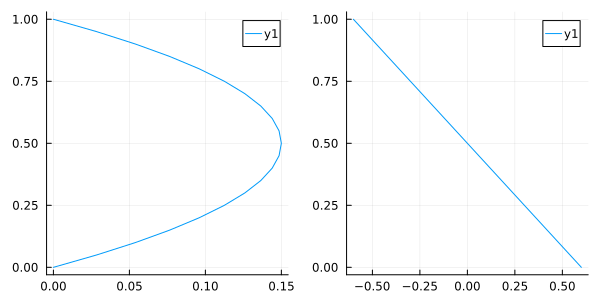

In [142]:
z = 0:0.05:1.0
K = similar(z)
dKdz = similar(z)
for i in 1:length(z)
    K[i] = parabola_diffusion(z[i])
    dKdz[i] = derivative_parabola_diffusion(z[i])
end
l = @layout([a b]);
p1 = plot(K,z)
p2 = plot(dKdz, z)
plot(p1,p2,size=(600,300),layout=l)


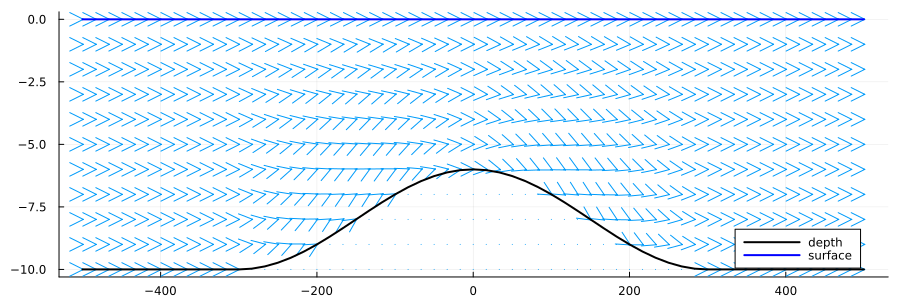

In [143]:
#plot flow field

#grid for plotting
d_m=d["d_m"];L=d["L"];u_m=d["u_m"]
xgrid=-L:(L/30):L
zgrid=-d_m:(d_m/10):0.0
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

Plots.default(:size, d["plot_maps_size"])
scale_u=1.0
scale_w=1.0

#heatmap(xgrid,zgrid,w.(xs,0.0,zs,0.0)')
quiver(vec(xs),vec(zs),quiver=(scale_u*u.(vec(xs),0.0,vec(zs),0.0),scale_w*w.(vec(xs),0.0,vec(zs),0.0)),
    arrowscale=0.6, headsize=0.1)
plot!(xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")

In [144]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes time derivative ds of s at current time t
for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
   ∂s.x = u(x, y, z, t)
   # dy/dt=v
   ∂s.y = v(x, y, z, t)
   # dz/dt=0
   depth_z = depth(x, d_m, d_b, l_b)
   #z_nd = (z+depth_z)/depth_z 
   z_nd = (z+d_m)/d_m #d_m is the depth of the computation domain
   if z_nd<=1 && z_nd>=0
      ∂s.z = w(x,y,z,t) + derivative_parabola_diffusion(z_nd) 
   else
      ∂s.z = 0
   end
   # age=(t-t0)
   ∂s.t = 1.0
end

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
   ∂s.x = 0.0
   # dy/dt=v
   ∂s.y = 0.0
   # dz/dt=0
   depth_z = depth(x, d_m, d_b, l_b)
   #z_nd = (z+depth_z)/depth_z 
   z_nd = (z+d_m)/d_m 
   if z_nd<=1 && z_nd>=0
      ∂s.z = sqrt(2 * parabola_diffusion(z_nd))
   else
      ∂s.z = 0
   end
   # age=(t-t0)
   ∂s.t = 0.0
end
d["f"] = f!
d["g"] = g!


g! (generic function with 1 method)

In [145]:
# use streamfunction as background for plotting

function plot_background(d)
    L = d["L"]
    # streamfunction for plot
     x1 = -L:(L/100):L
     z1 = -d_m:(d_m/100):0.0
     flow = zeros(length(x1), length(z1))
     for i = 1:length(x1)
         for j = 1:length(z1)
             flow[i,j] = stream(x1[i], 0.0, z1[j], 0.0)
         end
     end
     f = contour(x1, z1, flow', legend=false)
     return(f)
 end
 d["plot_maps_background"] = plot_background
 

plot_background (generic function with 1 method)

In [146]:
run_simulation(d)

writing output to memory at t = 

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0  …  210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0]
interrupt simulation for output at t = [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0  …  210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0]
Simulation from time 0.0s to 300.0s since 2000-01-01T00:00:00
t=0.0 -> 0.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 0.0%
simulate! runs for once.
t=0.0 -> 10.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:10 : 3.3%


The deterministic w-velocity is0.44334071133186326
The stochastic w-velocity is0.38732936802485124
The deterministic w-velocity is0.3943846416248947
The stochastic w-velocity is0.42685481905074696
The deterministic w-velocity is0.3571066161843737
The stochastic w-velocity is0.4518018522293727
The deterministic w-velocity is0.34744415929047134
The stochastic w-velocity is0.4577279440241499
The deterministic w-velocity is0.38319235031433757
The stochastic w-velocity is0.4351422343800027
The deterministic w-velocity is0.24431785638045914
The stochastic w-velocity is0.5066348484378461
The deterministic w-velocity is0.05240640533036313
The stochastic w-velocity is0.5465241757924095
The deterministic w-velocity is-0.07223193673113378
The stochastic w-velocity is0.5425020771690986
The deterministic w-velocity is-0.07924330064507973
The stochastic w-velocity is0.5415780783181026
The deterministic w-velocity is0.025003158821779115
The stochastic w-velocity is0.5476051417381842
simulate! runs fo

0.18325434942008115
The stochastic w-velocity is0.5265650671120947
The deterministic w-velocity is0.059247629327826366
The stochastic w-velocity is0.5462556787239776
The deterministic w-velocity is0.1094210689783317
The stochastic w-velocity is0.5411389446831837
The deterministic w-velocity is-0.009118559114847703
The stochastic w-velocity is0.5473158072602667
The deterministic w-velocity is-0.06686477194213196
The stochastic w-velocity is0.5428811438081931
The deterministic w-velocity is-0.0652257861538103
The stochastic w-velocity is0.5430623723093028
simulate! runs for once.
t=30.0 -> 40.0  : 2000-01-01T00:00:30 -> 2000-01-01T00:00:40 : 13.3%
The deterministic w-velocity is-0.08129719212451345
The stochastic w-velocity is0.5409756599002624
The deterministic w-velocity is0.029406254697167157
The stochastic w-velocity is0.5475731616481453
The deterministic w-velocity is0.040312476919580564
The stochastic w-velocity is0.5472645474812857
The deterministic w-velocity is0.0833912433300956

0.09188772204755111
The stochastic w-velocity is0.5436862458218636
The deterministic w-velocity is0.09006330015410594
The stochastic w-velocity is0.5438925092468146
The deterministic w-velocity is0.025779130943367062
The stochastic w-velocity is0.5476707898801887
The deterministic w-velocity is-0.028067521074886016
The stochastic w-velocity is0.5462364129804996
The deterministic w-velocity is-0.09298711185963275
The stochastic w-velocity is0.5388878576445182
The deterministic w-velocity is-0.0511176081143842
The stochastic w-velocity is0.5443257649953466
The deterministic w-velocity is-0.049398339941272656
The stochastic w-velocity is0.5444871561466417
The deterministic w-velocity is-0.07698174549655323
The stochastic w-velocity is0.5412483021363773
The deterministic w-velocity is-0.12845206499595369
The stochastic w-velocity is0.5321553324551813
The deterministic w-velocity is-0.041755816406040036
The stochastic w-velocity is0.5451666717391125
simulate! runs for once.
t=60.0 -> 70.0  

t=90.0 -> 100.0  : 2000-01-01T00:01:30 -> 2000-01-01T00:01:40 : 33.3%
The deterministic w-velocity is-0.3477698679716285
The stochastic w-velocity is0.44149951396967885
The deterministic w-velocity is-0.27295664186653035
The stochastic w-velocity is0.4832582916032779
The deterministic w-velocity is-0.2624500058463546
The stochastic w-velocity is0.4881388491709096
The deterministic w-velocity is-0.27342871966823334
The stochastic w-velocity is0.48308969900729415
The deterministic w-velocity is-0.22246168256912519
The stochastic w-velocity is0.5046719011823548
The deterministic w-velocity is-0.19222361928031467
The stochastic w-velocity is0.5151898819179835
The deterministic w-velocity is-0.0851197077316141
The stochastic w-velocity is0.5401383859813695
The deterministic w-velocity is-0.01300208499133862
The stochastic w-velocity is0.5470708272245126
The deterministic w-velocity is0.006193638021304303
The stochastic w-velocity is0.5476395401071749
The deterministic w-velocity is-0.016928

The stochastic w-velocity is0.5124798959769434
simulate! runs for once.
t=120.0 -> 130.0  : 2000-01-01T00:02:00 -> 2000-01-01T00:02:10 : 43.3%
The deterministic w-velocity is-0.22522927204055812
The stochastic w-velocity is0.5049672804695471
The deterministic w-velocity is-0.12267814675647427
The stochastic w-velocity is0.5343998800918194
The deterministic w-velocity is-0.034281929660118615
The stochastic w-velocity is0.5462187264888132
The deterministic w-velocity is-0.07233713669764281
The stochastic w-velocity is0.54264905508569
The deterministic w-velocity is-0.06029962808449043
The stochastic w-velocity is0.5440564497172549
The deterministic w-velocity is-0.16227270373172986
The stochastic w-velocity is0.5254684341617573
The deterministic w-velocity is-0.28040307893499333
The stochastic w-velocity is0.4818328689301193
The deterministic w-velocity is-0.1987679913363456
The stochastic w-velocity is0.5148735507158915
The deterministic w-velocity is-0.27130563231102883
The stochastic 


The stochastic w-velocity is0.418253679223844
The deterministic w-velocity is-0.2974858080355555
The stochastic w-velocity is0.47663024218328837
The deterministic w-velocity is-0.2495751289980828
The stochastic w-velocity is0.49911023652070624
The deterministic w-velocity is-0.15209564093665773
The stochastic w-velocity is0.530662220687427
The deterministic w-velocity is-0.15095291312362494
The stochastic w-velocity is0.5310148611676386
simulate! runs for once.
t=160.0 -> 170.0  : 2000-01-01T00:02:40 -> 2000-01-01T00:02:50 : 56.7%
The deterministic w-velocity is-0.03326160646703023
The stochastic w-velocity is0.5471303626160777
The deterministic w-velocity is-0.016439231023092603
The stochastic w-velocity is0.5476395990892188
The deterministic w-velocity is-0.020278836803061286
The stochastic w-velocity is0.5475763955246233
The deterministic w-velocity is-0.1307634274781906
The stochastic w-velocity is0.5356655571226365
The deterministic w-velocity is-0.21534183749531258
The stochasti

simulate! runs for once.
t=170.0 -> 180.0  : 2000-01-01T00:02:50 -> 2000-01-01T00:03:00 : 60.0%
The deterministic w-velocity is-0.06726694025474791
The stochastic w-velocity is0.5451405799165514
The deterministic w-velocity is-0.00404509837030882
The stochastic w-velocity is0.5476902339517056
The deterministic w-velocity is0.0455358278430987
The stochastic w-velocity is0.54520931471572
The deterministic w-velocity is0.09793469719998606
The stochastic w-velocity is0.5382278227346622
The deterministic w-velocity is0.09793469719998606
The stochastic w-velocity is0.5382278227346622
The deterministic w-velocity is0.09793469719998606
The stochastic w-velocity is0.5382278227346622
The deterministic w-velocity is0.014560405826977745
The stochastic w-velocity is0.547181386282192
The deterministic w-velocity is-0.025698377048148213
The stochastic w-velocity is0.5475728580215622
The deterministic w-velocity is-0.006015343338112497
The stochastic w-velocity is0.5476912206710294
The deterministic w

-0.17705141725769552
The stochastic w-velocity is0.5262391913511415
The deterministic w-velocity is-0.13404532637764455
The stochastic w-velocity is0.5362630351403269
The deterministic w-velocity is-0.10128537376576636
The stochastic w-velocity is0.5417624696400973
The deterministic w-velocity is-0.07435277486432297
The stochastic w-velocity is0.5449386891478029
simulate! runs for once.
t=190.0 -> 200.0  : 2000-01-01T00:03:10 -> 2000-01-01T00:03:20 : 66.7%
The deterministic w-velocity is0.08444909517999956
The stochastic w-velocity is0.5396122043502859
The deterministic w-velocity is0.02815727358966404
The stochastic w-velocity is0.5461588398153934
The deterministic w-velocity is-0.08783381640370388
The stochastic w-velocity is0.5435789783837245
The deterministic w-velocity is0.06110925500151271
The stochastic w-velocity is0.5428770780705485
The deterministic w-velocity is0.057653852481802687
The stochastic w-velocity is0.5432757840115474
The deterministic w-velocity is0.00623290000453


The stochastic w-velocity is0.5450186050998272
The deterministic w-velocity is0.04097624436482761
The stochastic w-velocity is0.5450186050998272
The deterministic w-velocity is-0.012437377537563497
The stochastic w-velocity is0.5477053836465228
The deterministic w-velocity is0.03476765021253674
The stochastic w-velocity is0.545540225188751
simulate! runs for once.
t=200.0 -> 210.0  : 2000-01-01T00:03:20 -> 2000-01-01T00:03:30 : 70.0%
The deterministic w-velocity is-0.016322848807797104
The stochastic w-velocity is0.5477217099078074
The deterministic w-velocity is0.00594840635958957
The stochastic w-velocity is0.5472793296521675
The deterministic w-velocity is-0.04107906960106338
The stochastic w-velocity is0.5472775127556766
The deterministic w-velocity is-0.11156774381768247
The stochastic w-velocity is0.540562048468821
The deterministic w-velocity is-0.1108176279190093
The stochastic w-velocity is0.5406905827336134
The deterministic w-velocity is-0.10064369432093462
The stochastic w


The stochastic w-velocity is0.5355517497984841
The deterministic w-velocity is0.07639981429600497
The stochastic w-velocity is0.5404452894140834
The deterministic w-velocity is0.030130770673332596
The stochastic w-velocity is0.5458400674721334
The deterministic w-velocity is0.06382777861495842
The stochastic w-velocity is0.542280362191198
The deterministic w-velocity is0.10337937308017153
The stochastic w-velocity is0.5356922734415387
The deterministic w-velocity is0.08891458052185584
The stochastic w-velocity is0.538427976039544
The deterministic w-velocity is0.1220716394907895
The stochastic w-velocity is0.5316811834900793
The deterministic w-velocity is0.04339169680417093
The stochastic w-velocity is0.5446973886086547
The deterministic w-velocity is0.13439727597737353
The stochastic w-velocity is0.5287264207397356
simulate! runs for once.
t=240.0 -> 250.0  : 2000-01-01T00:04:00 -> 2000-01-01T00:04:10 : 83.3%
The deterministic w-velocity is0.15722583611390956
The stochastic w-veloci

-0.1397648193922583
The stochastic w-velocity is0.535089488549113
The deterministic w-velocity is-0.12154766583163136
The stochastic w-velocity is0.5385164632347657
The deterministic w-velocity is-0.05154910984918468
The stochastic w-velocity is0.5466283715979763
The deterministic w-velocity is-0.1184746828916223
The stochastic w-velocity is0.5390087456770176
simulate! runs for once.
t=270.0 -> 280.0  : 2000-01-01T00:04:30 -> 2000-01-01T00:04:40 : 93.3%
The deterministic w-velocity is-0.06571878694634849
The stochastic w-velocity is0.5456091576045871
The deterministic w-velocity is-0.029593305561981895
The stochastic w-velocity is0.547533311774395
The deterministic w-velocity is-0.07510802805335617
The stochastic w-velocity is0.544742691117875
The deterministic w-velocity is-0.09220785011176932
The stochastic w-velocity is0.5428170761078729
The deterministic w-velocity is0.008776800199243076
The stochastic w-velocity is0.5473152714717711
The deterministic w-velocity is0.016047717976730

In [147]:
fig2 = d["plot_maps_background"](d)
savefig(fig2, ".//result//stream_function_bump.png")


"j:\\Master_Thesis\\particles.jl\\example_notebooks\\result\\stream_function_bump.png"

In [148]:
d["all_particles"][1][1]

-200.01034034514936

In [149]:
#t_all=d["keep_particle_times"]
#output_Ninterval = 10
#fig2 = d["plot_maps_background"](d)
#d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
#plot!(fig2,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
#plot!(fig2,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
#d["plot_maps_func"] = plot_maps_xz

#anim = @animate for i in 1:output_Ninterval:length(t_all)
#    p_temp=d["all_particles"]
#    d["plot_maps_func"](fig2, d, p_temp[i])
#end
#fname = "./mixing_outside_prevention.gif"
#gif(anim, fname, fps=1)

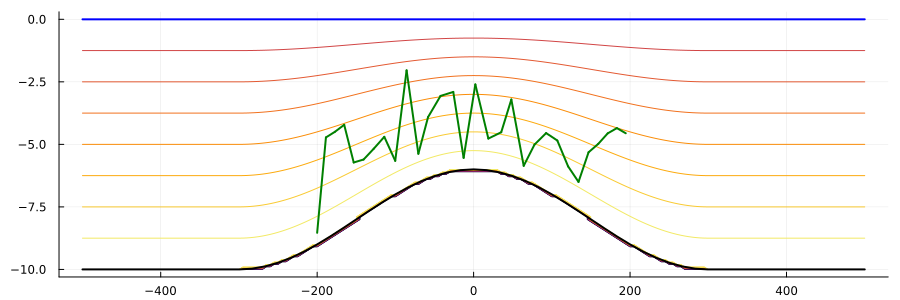

In [150]:
function if_inside(p)
    x,_,z,_ = p
    if_inside_xdir = x>-500 && x<500
    if_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return if_inside_xdir && if_inside_zdir
end
fig = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["all_particles"]
p = t[1]
for i=2:length(t)-1
    if if_inside(t[i])
        plot!(fig,[p[1],t[i][1]],[p[3],t[i][3]], color=:green, lw=2)
        p = t[i]
        #plot!(label="particle trajectory", legend=:best)
    else
        plot!(fig,[p[1],t[i][1]],[p[3],t[i][3]], color=:green, lw=2, ls=:dash)
    end
end
display(fig)

In [151]:
length(d["all_particles"])

31

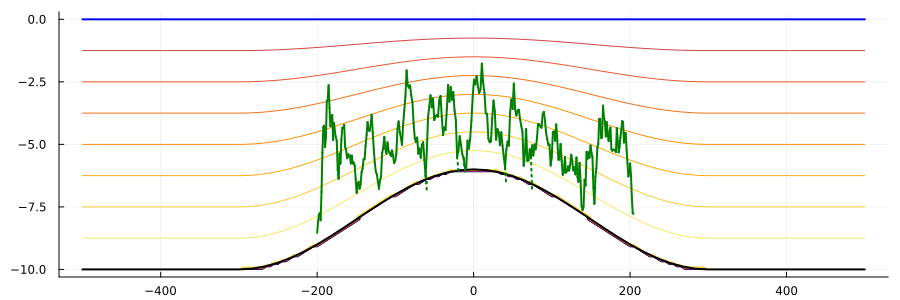

"j:\\Master_Thesis\\particles.jl\\example_notebooks\\result\\particle_hit_ground.png"

In [155]:
function if_inside(p)
    x,_,z,_ = p
    if_inside_xdir = x>-500 && x<500
    if_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return if_inside_xdir && if_inside_zdir
end

fig = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["the_virtual_trajectory"]
p = t[:, 1]
for i=2:size(t)[2]-1
    if if_inside(t[:,i])
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:green, lw=2)
        p = t[:, i]
        #plot!(label="particle trajectory", legend=:best)
    else
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:green, lw=2, ls=:dot)
    end
end
display(fig)
savefig(fig, ".//result//particle_hit_ground.png")